In [1]:
### 사용할 라이브러리
# - 데이터처리
import pandas as pd
import numpy as np

# - 정규화
from sklearn.preprocessing import StandardScaler

# - 데이터분류
from sklearn.model_selection import train_test_split

# - 하이퍼파라메터 튜닝
from sklearn.model_selection import GridSearchCV

# - 분류모델
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier

# - 평가
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# - 오차행렬 매트릭스 및 오차행렬도
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
"""
* 주제 : 와인분류하기
 - 사용데이터 : 08_wine.csv

* 분석방법
 - 스케일링 : 스탠다드 스케일러 사용
 - 데이터 분류 : 훈련/검증/테스트 = 6:2:2로 분류하여 사용
 - 하이퍼파라메터 튜닝 진행

 <튜닝 속성>
  - HGB : max_iter = [50, 100]
        : max_depth = [None, 10]
        : min_samples_leaf = [1, 2, 4]

  - XGB : n_estimators = [50, 100]
        : max_depth = [None, 10]
        : min_child_weight = [1, 2, 4]

  - 나머지 모델 : n_estimators = [50, 100]
               : max_depth = [None, 10]
               : min_samples_split = [2, 5]
               : min_samples_leaf = [1, 2, 4]

  - scoring = accuracy 사용
  - cv = 5 사용
  - refit은 사용안해도 됨

<최종결과>
 - 데이터프레임에 담아서 출력
   * 컬럼명 : 모델명, 훈련정확도, 검증정확도, (훈련-검증), 정밀도, 재현율, F1-score

 - 최종모델 선정 후
   * 테스트정확도, 정밀도, 재현율, F1-score 확인
 - 하이퍼파라메터 튜닝 전과 튜닝 후로 구분하여 모델 선정

"""

'\n* 주제 : 와인분류하기\n - 사용데이터 : 08_wine.csv\n\n* 분석방법\n - 스케일링 : 스탠다드 스케일러 사용\n - 데이터 분류 : 훈련/검증/테스트 = 6:2:2로 분류하여 사용\n - 하이퍼파라메터 튜닝 진행\n\n <튜닝 속성>\n  - HGB : max_iter = [50, 100]\n        : max_depth = [None, 10]\n        : min_samples_leaf = [1, 2, 4]\n\n  - XGB : n_estimators = [50, 100]\n        : max_depth = [None, 10]\n        : min_child_weight = [1, 2, 4]\n\n  - 나머지 모델 : n_estimators = [50, 100]\n               : max_depth = [None, 10]\n               : min_samples_split = [2, 5]\n               : min_samples_leaf = [1, 2, 4]\n\n  - scoring = accuracy 사용\n  - cv = 5 사용\n  - refit은 사용안해도 됨\n\n<최종결과>\n - 데이터프레임에 담아서 출력\n   * 컬럼명 : 모델명, 훈련정확도, 검증정확도, (훈련-검증), 정밀도, 재현율, F1-score\n\n - 최종모델 선정 후\n   * 테스트정확도, 정밀도, 재현율, F1-score 확인\n - 하이퍼파라메터 튜닝 전과 튜닝 후로 구분하여 모델 선정\n\n'

In [3]:
file_path = "./data/08_wine.csv"
data = pd.read_csv(file_path)
data

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0
...,...,...,...,...
6492,11.2,1.6,3.27,1.0
6493,9.6,8.0,3.15,1.0
6494,9.4,1.2,2.99,1.0
6495,12.8,1.1,3.34,1.0


In [4]:
X = data.iloc[:, :-1]
y = data["class"]
len(X), len(y)

(6497, 6497)

In [5]:
ss = StandardScaler()
ss.fit(X)

X_scaler = ss.transform(X)
X_scaler.shape

(6497, 3)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaler, y, test_size=0.4, random_state=42)
(X_train.shape, y_train.shape), (X_temp.shape, y_temp.shape)

(((3898, 3), (3898,)), ((2599, 3), (2599,)))

In [7]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
(X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((1299, 3), (1299,)), ((1300, 3), (1300,)))

In [8]:
### 오차행렬 및 오차행렬도 그리기를 함수로 정의
def conf_matrix_display(X_target, y_pred, model) :
    cm = confusion_matrix(X_target, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

In [9]:
### 하이퍼파라메터 튜닝 전 처리............................

In [10]:
### 훈련 시키기, 정확도확인, 예측, 평가를 하나의 함수로 정의해 놓기(기능 정의)
# - 함수 이름 : train_and_evalute_model

def train_and_evalute_model(model, train_input, train_target, val_input, val_target) :

    ### 모델 훈련 시키기
    model.fit(train_input, train_target)

    ### 훈련 및 검증 독립변수로 정확도 확인하기
    train_score = model.score(train_input, train_target)
    val_score   = model.score(val_input, val_target)

    ### 훈련 및 검증 데이터를 이용해서 예측 및 평가하기
    # - 훈련 예측 및 평가
    train_pred = model.predict(train_input)
    ### 정확도(accuracy_score)
    train_acc = accuracy_score(train_target, train_pred)
    ### 정밀도(precision_score)
    train_pre = precision_score(train_target, train_pred)
    ### 재현율(recall_score)
    train_rec = recall_score(train_target, train_pred)
    ### F1-score
    train_f1 = f1_score(train_target, train_pred)
    ### 오차행렬도
    # conf_matrix_display(train_target, train_pred, model)

    # - 검증 예측 및 평가
    val_pred = model.predict(val_input)
    ### 정확도(accuracy_score)
    val_acc = accuracy_score(val_target, val_pred)
    ### 정밀도(precision_score)
    val_pre = precision_score(val_target, val_pred)
    ### 재현율(recall_score)
    val_rec = recall_score(val_target, val_pred)
    ### F1-score
    val_f1 = f1_score(val_target, val_pred)
    ### 오차행렬도
    # conf_matrix_display(val_target, val_pred, model)

    # print("--------------[종료]--------------")
    return model, train_score, train_pre, train_rec, train_f1, val_score, val_pre, val_rec, val_f1

In [11]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
gb = GradientBoostingClassifier()
hgb = HistGradientBoostingClassifier()
xgb = XGBClassifier()

models = [rf, et, gb, hgb, xgb]
models

[RandomForestClassifier(),
 ExtraTreesClassifier(),
 GradientBoostingClassifier(),
 HistGradientBoostingClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)]

In [12]:
### 함수 반복 호출하기 ..............................
results = {}

# - 각 모델의 실행결과를 데이터프레임에 담을 변수 정의
rs_df = pd.DataFrame()

for m in models :
    ### 모델은 클래스로 되었기 때문에-> 클래스 이름을 추출 할 수 있습니다.
    modelName = m.__class__.__name__
    print(f"----------------[{modelName}]----------------")

    ### 함수 호출하기
    model, train_score, train_pre, train_rec, train_f1, val_score, val_pre, val_rec, val_f1 = train_and_evalute_model(
                                                                                                m, X_train, y_train, X_val, y_val)

    ### 딕셔너리에 모델 별로 결과값 담기
    results[modelName] = [model, train_score, train_pre, train_rec, train_f1, val_score, val_pre, val_rec, val_f1]

    ### 데이터프레임에 모델 별로 결과값 담기
    rs_temp = pd.DataFrame([[modelName, train_score, train_pre, train_rec, train_f1, val_score, val_pre, val_rec, val_f1, train_score-val_score]],
                            columns=["modelName", "train_score", "train_pre", "train_rec", "train_f1",
                                        "val_score", "val_pre", "val_rec", "val_f1", "train_score-val_score"])

    ### 원본 데이터프레임에 rs_temp 데이터를 행단위로 추가하기
    rs_df = pd.concat([rs_df, rs_temp], ignore_index=True)

    # print()

----------------[RandomForestClassifier]----------------
----------------[ExtraTreesClassifier]----------------
----------------[GradientBoostingClassifier]----------------
----------------[HistGradientBoostingClassifier]----------------
----------------[XGBClassifier]----------------


In [13]:
results

{'RandomForestClassifier': [RandomForestClassifier(),
  0.9974345818368394,
  0.9973181361045927,
  0.9993281827342962,
  0.9983221476510067,
  0.8806774441878368,
  0.922360248447205,
  0.917610710607621,
  0.9199793495095508],
 'ExtraTreesClassifier': [ExtraTreesClassifier(),
  0.9974345818368394,
  0.9996631862579993,
  0.9969768223043333,
  0.9983181971072991,
  0.8883756735950731,
  0.9240246406570842,
  0.9268795056642637,
  0.9254498714652957],
 'GradientBoostingClassifier': [GradientBoostingClassifier(),
  0.8917393535146229,
  0.9225934502150182,
  0.9368491770238495,
  0.9296666666666666,
  0.8629715165511932,
  0.9117341640706127,
  0.9042224510813595,
  0.9079627714581179],
 'HistGradientBoostingClassifier': [HistGradientBoostingClassifier(),
  0.9402257567983582,
  0.9635135135135136,
  0.958011420893517,
  0.9607545898601988,
  0.8768283294842186,
  0.928194297782471,
  0.9052523171987642,
  0.9165797705943691],
 'XGBClassifier': [XGBClassifier(base_score=None, booster=No

In [14]:
rs_df

,modelName,train_score,train_pre,train_rec,train_f1,val_score,val_pre,val_rec,val_f1,train_score-val_score
0,RandomForestClassifier,0.997435,0.997318,0.999328,0.998322,0.880677,0.922360,0.917611,0.919979,0.116757
1,ExtraTreesClassifier,0.997435,0.999663,0.996977,0.998318,0.888376,0.924025,0.926880,0.925450,0.109059
2,GradientBoostingClassifier,0.891739,0.922593,0.936849,0.929667,0.862972,0.911734,0.904222,0.907963,0.028768
3,HistGradientBoostingClassifier,0.940226,0.963514,0.958011,0.960755,0.876828,0.928194,0.905252,0.916580,0.063397
4,XGBClassifier,0.959979,0.972213,0.975479,0.973843,0.872209,0.922350,0.905252,0.913721,0.087770


In [15]:
"""
(해석)
 - 가장 일반화가 잘된 모델은 GB모델이며, 그 다음으로 HGB, XGB 순으로 나타남
 - 재현율의 경우에는 ET모델이 가장 높으나, GB모델과 많은 차이을 보이고 있지 않기에
   가장 일반화가 잘 된 GB모델로 선정
"""

'\n(해석)\n - 가장 일반화가 잘된 모델은 GB모델이며, 그 다음으로 HGB, XGB 순으로 나타남\n - 재현율의 경우에는 ET모델이 가장 높으나, GB모델과 많은 차이을 보이고 있지 않기에\n   가장 일반화가 잘 된 GB모델로 선정\n'

In [16]:
### ### 하이퍼파라메터 튜닝 후 처리 .........................

In [17]:
### 하이퍼파라메터 튜닝을 위한 함수 생성하기...........................
# - 함수 이름 : get_HyperParameter_Tuning()

def get_HyperParameter_Tuning(model, gridParam, scoring,
                                train_input, train_target, val_input, val_target, cv=5, n_jobs=-1) :
    ### 튜닝객체 생성하기
    grid_search_model = GridSearchCV(model, gridParams, scoring=scoring,
                                     cv=cv, n_jobs=n_jobs)

    ### 튜닝객체 훈련시키기 (모델 훈련시키기)
    grid_search_model.fit(train_input, train_target)

    ### 최적의 모델을 변수로 받아오기
    best_model = grid_search_model.best_estimator_

    ### 훈련데이터로 예측 및 평가결과 확인하기
    # - 훈련 예측하기
    train_pred = best_model.predict(train_input)
    ### 정확도(accuracy_score)
    train_acc = accuracy_score(train_target, train_pred)
    ### 정밀도(precision_score)
    train_pre = precision_score(train_target, train_pred)
    ### 재현율(recall_score)
    train_rec = recall_score(train_target, train_pred)
    ### F1-score
    train_f1 = f1_score(train_target, train_pred)
    ### 오차행렬도
    # conf_matrix_display(train_target, train_pred, model)

    ### 검증데이터로 예측 및 평가결과 확인하기
    val_pred = best_model.predict(val_input)
    ### 정확도(accuracy_score)
    val_acc = accuracy_score(val_target, val_pred)
    ### 정밀도(precision_score)
    val_pre = precision_score(val_target, val_pred)
    ### 재현율(recall_score)
    val_rec = recall_score(val_target, val_pred)
    ### F1-score
    val_f1 = f1_score(val_target, val_pred)
    ### 오차행렬도
    # conf_matrix_display(val_target, val_pred, model)

    return best_model, train_acc, train_pre, train_rec, train_f1, val_acc, val_pre, val_rec, val_f1

In [18]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
gb = GradientBoostingClassifier()
hgb = HistGradientBoostingClassifier()
xgb = XGBClassifier()

models = [rf, et, gb, hgb, xgb]
models

[RandomForestClassifier(),
 ExtraTreesClassifier(),
 GradientBoostingClassifier(),
 HistGradientBoostingClassifier(),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)]

In [19]:
### 튜닝 함수 호출하기
# - 각 모델 리턴 결과 저장할 딕셔너리 변수 정의
results = {}

# - 각 모델의 실행결과를 데이터프레임에 담을 변수 정의
rs_df = pd.DataFrame()

for m in models :
    ### 모델 이름 추출
    modelName = m.__class__.__name__
    print(f"---------------[{modelName}]--------------------")

    ### 하이퍼파라메터 속성이름과 값 범위 지정하기
    # - 모델마다 속성이름이 다르기에 조건식으로 정의해야함

    ### 하이퍼파라메터를 담을 딕셔너리 변수 정의
    gridParams = {}

    ### HistGradientBoostingClassifier 모델인 경우
    if modelName == "HistGradientBoostingClassifier" :
        # - 트리 갯수 지정(보통 50~1000 사이값 사용)
        gridParams["max_iter"] = [50, 100]

        # - 트리가 뻗어나가는 최대깊이 지정(None은 제안두지 않음, 보통 3~10 사이값 사용)
        gridParams["max_depth"] = [None, 10]

        # - 리프노드(결정노드)의 최소한의 샘플 수(보통 1~10 사잇값 사용)
        gridParams["min_samples_leaf"] = [1, 2, 4]

    ### XGBClassifier인 경우
    elif modelName == "XGBClassifier" :
        # - 트리 갯수 지정(보통 50~1000 사이값 사용)
        gridParams["n_estimators"] = [50, 100]

        # - 트리가 뻗어나가는 최대깊이 지정(None은 제안두지 않음, 보통 3~10 사이값 사용)
        gridParams["max_depth"] = [None, 10]

        # - 리프노드(결정노드)의 최소한의 샘플 수(보통 1~10 사잇값 사용)
        gridParams["min_child_weight"] = [1, 2, 4]

    ### RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier인 경우
    else :
        # - 트리 갯수 지정(보통 50~1000 사이값 사용)
        gridParams["n_estimators"] = [50, 100]

        # - 트리가 뻗어나가는 최대깊이 지정(None은 제안두지 않음, 보통 3~10 사이값 사용)
        gridParams["max_depth"] = [None, 10]

        # - 노드를 분할하기 위한 최소한의 샘플 수(보통 2~10 사잇값 사용)
        gridParams["min_samples_split"] = [2, 5]

        # - 리프노드(결정노드)의 최소한의 샘플 수(보통 1~10 사잇값 사용)
        gridParams["min_samples_leaf"] = [1, 2, 4]

    ### 평가방법
    scoring = "accuracy"

    ### 모델선정방법(기준값) 지정
    # refit = "accuracy"

    ### 함수 호출하기 ---------------------------------------------
    best_model, train_acc, train_pre, train_rec, train_f1, val_acc, val_pre, val_rec, val_f1 = get_HyperParameter_Tuning(
                                                                                                m, gridParams, scoring,
                                                                                                X_train, y_train, X_val, y_val)
    # print(best_model, train_acc, train_pre, train_rec, train_f1, val_acc, val_pre, val_rec, val_f1)

    ### 딕셔너리에 모델 별로 결과값 담기
    results[modelName] = [best_model, train_acc, train_pre, train_rec, train_f1, val_acc, val_pre, val_rec, val_f1]

    ### 데이터프레임에 모델 별로 결과값 담기
    rs_temp = pd.DataFrame([[modelName, train_acc, train_pre, train_rec, train_f1, val_acc, val_pre, val_rec, val_f1, train_acc-val_acc]],
                            columns=["modelName", "train_acc", "train_pre", "train_rec", "train_f1",
                                        "val_acc", "val_pre", "val_rec", "val_f1", "train_acc-val_acc"])

    ### 원본 데이터프레임에 rs_temp 데이터를 행단위로 추가하기
    rs_df = pd.concat([rs_df, rs_temp], ignore_index=True)

---------------[RandomForestClassifier]--------------------
---------------[ExtraTreesClassifier]--------------------
---------------[GradientBoostingClassifier]--------------------
---------------[HistGradientBoostingClassifier]--------------------
---------------[XGBClassifier]--------------------


In [20]:
results

{'RandomForestClassifier': [RandomForestClassifier(),
  0.9971780400205233,
  0.9979852249832102,
  0.9983204568357407,
  0.9981528127623845,
  0.8806774441878368,
  0.922360248447205,
  0.917610710607621,
  0.9199793495095508],
 'ExtraTreesClassifier': [ExtraTreesClassifier(min_samples_split=5, n_estimators=50),
  0.9810159055926116,
  0.9820657588840916,
  0.9932818273429627,
  0.9876419505678022,
  0.8868360277136259,
  0.912,
  0.9392378990731205,
  0.9254185692541856],
 'GradientBoostingClassifier': [GradientBoostingClassifier(max_depth=10, min_samples_split=5),
  0.9974345818368394,
  0.9979859013091642,
  0.9986563654685925,
  0.9983210208193418,
  0.8814472671285605,
  0.9295478443743428,
  0.9104016477857878,
  0.9198751300728408],
 'HistGradientBoostingClassifier': [HistGradientBoostingClassifier(max_depth=10, min_samples_leaf=2),
  0.9507439712673166,
  0.9747698602113877,
  0.96036278132348,
  0.9675126903553299,
  0.876058506543495,
  0.9245283018867925,
  0.90834191555097

In [21]:
rs_df

,modelName,train_acc,train_pre,train_rec,train_f1,val_acc,val_pre,val_rec,val_f1,train_acc-val_acc
0,RandomForestClassifier,0.997178,0.997985,0.998320,0.998153,0.880677,0.922360,0.917611,0.919979,0.116501
1,ExtraTreesClassifier,0.981016,0.982066,0.993282,0.987642,0.886836,0.912000,0.939238,0.925419,0.094180
2,GradientBoostingClassifier,0.997435,0.997986,0.998656,0.998321,0.881447,0.929548,0.910402,0.919875,0.115987
3,HistGradientBoostingClassifier,0.950744,0.974770,0.960363,0.967513,0.876059,0.924528,0.908342,0.916364,0.074685
4,XGBClassifier,0.974859,0.982245,0.984884,0.983563,0.874519,0.917355,0.914521,0.915936,0.100340


In [22]:
"""
(해석)
 - 기존 하이퍼파라메터 튜닝 전에는 가장 일반화가 잘된 모델은 GB모델이었으나,
   튜닝 이후에는 HGB 모델이 가장 일반화 된것으로 분석되었음
 - 재현율의 경우에는 ET모델이 가장 높으나, HGB모델과 많은 차이을 보이고 있지 않기에
   가장 일반화가 잘 된 HGB모델로 선정하였음
"""

'\n(해석)\n - 기존 하이퍼파라메터 튜닝 전에는 가장 일반화가 잘된 모델은 GB모델이었으나,\n   튜닝 이후에는 HGB 모델이 가장 일반화 된것으로 분석되었음\n - 재현율의 경우에는 ET모델이 가장 높으나, HGB모델과 많은 차이을 보이고 있지 않기에\n   가장 일반화가 잘 된 HGB모델로 선정하였음\n'

In [23]:
### 최종 선정모델로 테스트하기...............................

train_acc=0.950744, test_acc=0.8592, train-test=0.0915, test_pre=0.9102, test_rec=0.8958, test_f1=0.9029


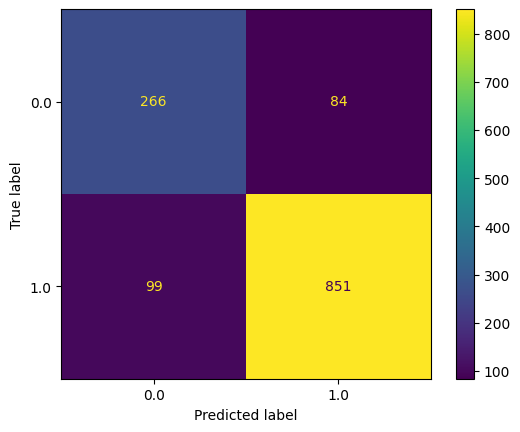

In [24]:
### 테스트 데이터로 예측 및 평가결과 확인하기
# 최종 선정모델 추출하기
f_model = results["HistGradientBoostingClassifier"][0]

test_pred = f_model.predict(X_test)
### 정확도(accuracy_score)
test_acc = accuracy_score(y_test, test_pred)
### 정밀도(precision_score)
test_pre = precision_score(y_test, test_pred)
### 재현율(recall_score)
test_rec = recall_score(y_test, test_pred)
### F1-score
test_f1 = f1_score(y_test, test_pred)

### 오차행렬도
conf_matrix_display(y_test, test_pred, f_model)

print(f"train_acc={0.950744}, test_acc={test_acc:.4f}, train-test={0.950744-test_acc:.4f}, \
test_pre={test_pre:.4f}, test_rec={test_rec:.4f}, test_f1={test_f1:.4f}")

In [25]:
"""
(해석)
 - 최종 선정한 HGB모델을 이용하여 테스트 데이터로 평가한 결과
 - 테스트 정확도 0.859, 테스트 재현율 0.896으로 일반화된 모델로
 - 와인을 분류하는 모델로 사용이 가능함
"""

'\n(해석)\n - 최종 선정한 HGB모델을 이용하여 테스트 데이터로 평가한 결과\n - 테스트 정확도 0.859, 테스트 재현율 0.896으로 일반화된 모델로\n - 와인을 분류하는 모델로 사용이 가능함\n'